# Convolutional neural network for sign language alphabet

### Euler Gomes da Rocha

## 1. Ambient preparation

In [99]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [100]:
import os

os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)

## 1.1 Packages import

In [101]:
import subprocess
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from joblib import dump, load

import progressbar

import pygame

import cv2
import time
import glob
import shutil

import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot

tensorflow.keras.utils.pydot = pyd

## 1.2 Check versions

In [102]:
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

print(f"Pandas version: {pd.__version__}")

import matplotlib

print(f"Matplotlib version: {matplotlib.__version__}")

print(f"Seaborn version: {sns.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.9.25 (main, Nov  3 2025, 22:44:01) [MSC v.1929 64 bit (AMD64)]
NumPy version: 1.26.4
TensorFlow version: 2.10.1
Pandas version: 2.3.3
Matplotlib version: 3.9.4
Seaborn version: 0.13.2
OpenCV version: 4.9.0


## 1.3 Check GPU

In [103]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: True
Dispositivos GPU TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Experiment parameters

## 2.1. Capture configuration

In [104]:
capture_time = 10  #capture time em seconds
capture_count = 25  #photo amount per class
img_size = 128  #photo size
box_size = 400  #capture boz size in pixels

new_capture = True  #performs a new photo capture if is equal True

## 2.2. Model and training configuration

In [105]:
new_model = True  #generate a new model
augmentation_exec = True  #perform data augmentation if is equal True
normalization_exec = True  #perform data nomatlization if is equal True

confidence_threshold = 0.6  #confidence to classify to none

model_name = 'cnn_sign_language'

class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
              'V', 'W', 'X', 'Y', 'Z']  #model classes
num_classes = len(class_name)

## 3. Image capture

## 3.1. Auxiliary capture functions

In [106]:
def prepare_capture_folder(base_path='dataset'):
    folder_path = os.path.join(base_path, 'capture')  #folder path to photo capture

    #if folder exists, delete and recreate
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f'Folder {folder_path} deleted')

    os.makedirs(folder_path)
    print(f'Folder {folder_path} created')
    return folder_path


def capture_images(class_name, num_images, capture_time, img_size, box_size, save_path):
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('Cannot open camera')
        return False

    capture_interval = capture_time / num_images

    print(f'\n=== Capturing {class_name.upper()} ===')
    print(f'position yourself in {class_name.upper()} and press SPACE to start!')
    print('Press Q to quit')

    window_name = 'Capture Images'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.flip(frame, 1)  #flip image to better position

            #add instructions in the screen
            cv2.putText(frame, f'Position yourself in {class_name.upper()}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                        (0, 255, 0), 2)
            cv2.putText(frame, f'Press SPACE to start', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            #draw the capture area
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size // 2, cy - box_size // 2),
                          (cx + box_size // 2, cy + box_size // 2), (0, 255, 0), 2)

            cv2.imshow(window_name, frame)

            key = cv2.waitKey(1) & 0xFF
            if key == ord(' '):
                break
            elif key == ord('q'):
                cap.release()
                cv2.destroyWindow(window_name)
                cv2.waitKey(1)
                return False

        #start capture with countdown
        start_time = time.time()
        images_captured = 0
        last_capture_time = 0

        while images_captured < num_images:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.flip(frame, 1)

            elapsed_time = time.time() - start_time
            remaining_time = max(0, capture_time - elapsed_time)

            #draw the capture area
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size // 2, cy - box_size // 2),
                          (cx + box_size // 2, cy + box_size // 2), (0, 0, 255), 2)

            #add the time countdown and photo capture count
            cv2.putText(frame, f'Tempo: {remaining_time:.1f}s', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Fotos: {images_captured}/{num_images}', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'{class_name.upper()}', (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow(window_name, frame)

            if elapsed_time - last_capture_time >= capture_interval:
                #extract the region os interest
                roi = frame[cy - box_size // 2:cy + box_size // 2,
                cx - box_size // 2:cx + box_size // 2]

                #convert to gray_scale
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                #resize to desired size
                roi_resized = cv2.resize(roi_gray, (img_size, img_size))

                #save image
                filename = os.path.join(save_path, f'{class_name}_{images_captured + 1:03d}.png')
                cv2.imwrite(filename, roi_resized)

                images_captured += 1
                last_capture_time = elapsed_time

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            if elapsed_time >= capture_time and images_captured >= num_images:
                break

    finally:
        #release camera and close the window
        cap.release()
        cv2.destroyWindow(window_name)

        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)

    print(f'{images_captured} images for {class_name.upper()} captured')
    return True

## 3.2. Image capture

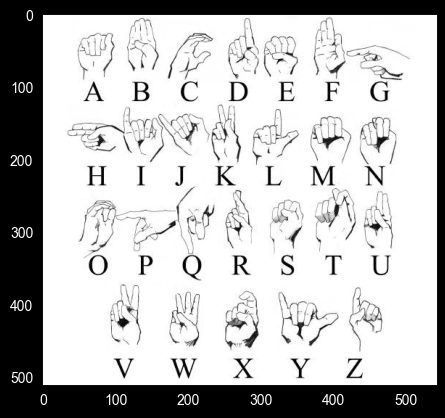

In [113]:
img = cv2.imread('support_files/sign_alphabet.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.grid(False)
plt.show()

In [108]:
if new_capture:
    capture_path = prepare_capture_folder()

    print('\n=== Capture Images ===')
    print(f'Time per class: {capture_time} seconds')
    print(f'Photos per class: {capture_count}')
    print(f'Capture area: {img_size} x {img_size} pixels')
    print(f'Capture area: {box_size} x {box_size} pixels')
    print('=' * 20)

    #capture per class
    for class_name in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
                       'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
        success = capture_images(class_name, capture_count, capture_time, img_size, box_size, capture_path)
        if not success:
            print(f'The class {class_name.upper()} not captured')
            break
        time.sleep(1)

    print('\n=== Capture finished ===')

else:
    capture_path = os.path.join('data', 'capture')
    if os.path.exists(capture_path):
        print(f'Using existent dataset: {capture_path}')
    else:
        print(f'Erorr: {capture_path} does not exist')
        print('Define new_capture as True to create a new dataset')

Folder dataset\capture deleted
Folder dataset\capture created

=== Capture Images ===
Time per class: 10 seconds
Photos per class: 25
Capture area: 128 x 128 pixels
Capture area: 400 x 400 pixels

=== Capturing A ===
position yourself in A and press SPACE to start!
Press Q to quit


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'Capture Images' in function 'cvDestroyWindow'


## 4. Data analyst

## 4.1. Load image dataset

In [ ]:
def load_images(folder_path, class_name, img_size):
    images = []
    labels = []

    for idx, class_name in enumerate([class_name]):
        pattern = os.path.join(folder_path, f'{class_name.lower()}_*.png')
        files = glob.glob(pattern)

        print(f'Found {class_name}: {len(files)} images')

        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(idx)

    return np.array(images), np.array(labels)

capture_path = os.path.join('dataset', 'capture')
x_data, y_data = load_images(capture_path, class_name, img_size)

print(f'Total images: {len(x_data)}')
print(f'Data shape: {x_data.shape}')
print(f'Label shape: {y_data.shape}')

## 4.2. Data visualisation